In [22]:
import kaggle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string



In [23]:
# ! kaggle datasets download -d uciml/sms-spam-collection-dataset -p ./data


# # Path where Kaggle saved your file
# zip_path = "sms-spam-collection-dataset.zip"
# extract_to = "data"

# os.makedirs(extract_to, exist_ok=True)

# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(extract_to)

# # print("✅ Extracted to:", os.path.abspath(extract_to))a

### 1. Data Loading

In [24]:
# Method 3: Use forward slashes (works on Windows too)
os.chdir("C:/Users/YASH/AI,ML book/CodSoft/Task-4")

print("Current directory:", os.getcwd())

# List files in current directory
print("Files in current directory:", os.listdir('.'))

# change directory to data

# Check if data directory exists
if os.path.exists('data'):
    print("Files in data directory:", os.listdir('data'))

dataFrame = pd.read_csv('data/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
dataFrame.head()

Current directory: C:\Users\YASH\AI,ML book\CodSoft\Task-4
Files in current directory: ['app.py', 'data', 'models', 'notebooks', 'requirements.txt', 'venv']
Files in data directory: ['sms-spam-collection-dataset']


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Data Cleaning and Preprocessing

In [25]:
df = dataFrame.copy()
print(df.shape)
print(df.columns)

print(f"\n{'='*20} Data Info {'='*20}\n")
df.info()

(5572, 5)
Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

==================== Data Info ====================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [26]:
# Check NaN Value
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [27]:
df.duplicated().sum()

np.int64(403)

In [28]:
# remove duplicate rows
df = df.drop_duplicates(keep='first')
# confirming duplicate removal
df.duplicated().sum()

np.int64(0)

In [29]:
# drop empty columns
df = df.dropna(axis=1, how='all')

# drop columns which are not required
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# rename the columns
df = df.rename(columns={'v1': 'target', 'v2': 'message'})

# Convert label to numerical values
label = LabelEncoder()
df['target'] = label.fit_transform(df['target']) 

# Remove rows with missing values
df = df.dropna()
print(df.shape)
df.head()

(5169, 2)


,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### EDA (Exploratory Data Analysis)

Target value counts:
target
0    4516
1     653
Name: count, dtype: int64


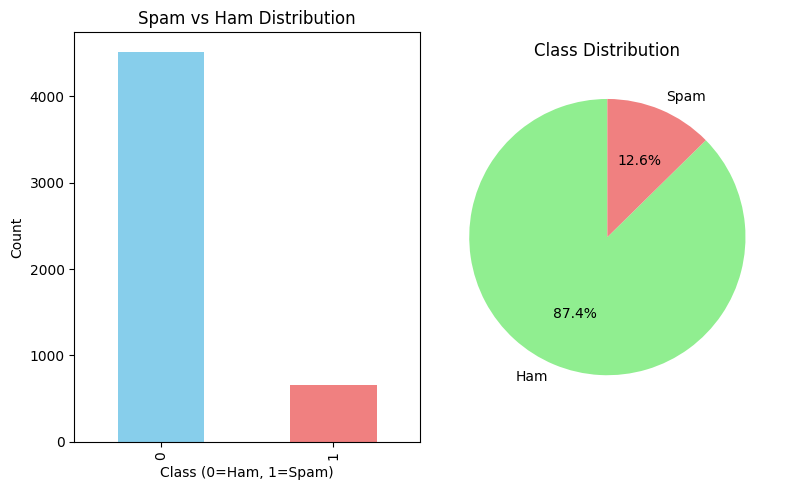


Total messages: 5169
Ham messages: 4516
Spam messages: 653
Spam percentage: 12.63%


In [30]:
# EDA
# Fix the EDA section - there's a typo in the column name
print("Target value counts:")
print(df['target'].value_counts())

# Visualize the class distribution
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Spam vs Ham Distribution')
plt.xlabel('Class (0=Ham, 1=Spam)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(df['target'].value_counts(), labels=['Ham', 'Spam'], autopct='%1.1f%%', 
        colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

# Display basic statistics
print(f"\nTotal messages: {len(df)}")
print(f"Ham messages: {len(df[df['target'] == 0])}")
print(f"Spam messages: {len(df[df['target'] == 1])}")
print(f"Spam percentage: {(len(df[df['target'] == 1])/len(df))*100:.2f}%")

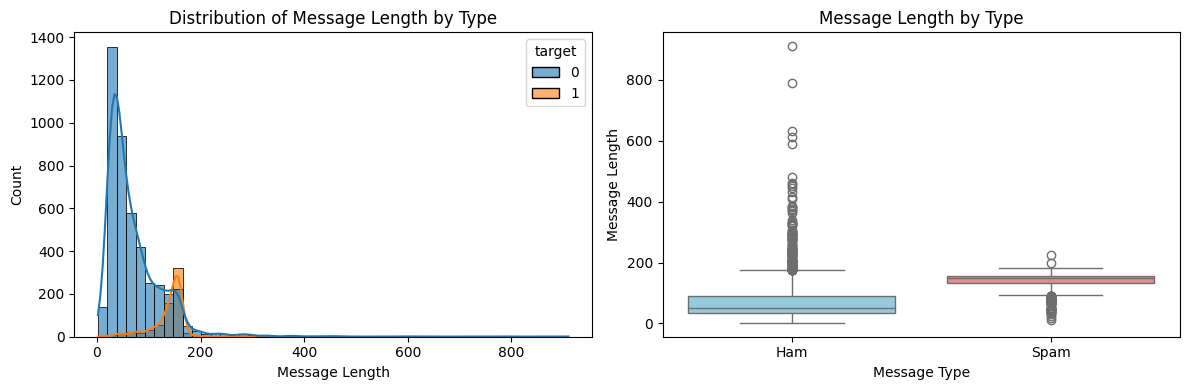


Average Message Length:
Ham messages: 70.46 characters
Spam messages: 137.89 characters


In [31]:
# bar plot

# Text Length Analysis
df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='message_length', hue='target',kde=True, bins=50, alpha=0.6)
plt.title('Distribution of Message Length by Type')
plt.xlabel('Message Length')

plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='message_length', data=df, palette=['skyblue', 'lightcoral'])
plt.title('Message Length by Type')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.xlabel('Message Type')
plt.ylabel('Message Length')

plt.tight_layout()
plt.show()

# Average length statistics
print("\nAverage Message Length:")
print(f"Ham messages: {df[df['target'] == 0]['message_length'].mean():.2f} characters")
print(f"Spam messages: {df[df['target'] == 1]['message_length'].mean():.2f} characters")

In [32]:
# Text Preprocessing

from matplotlib.pylab import astype


try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Apply preprocessing
df['cleaned_message'] = df['message'].apply(preprocess_text)

df['word_count'] = df['message'].apply(lambda x: len(x.split()))
df['char_count'] = df['message'].apply(len)
df['has_urgent'] = df['message'].str.contains(r'\b(?:urgent|asap|immediately|quick|fast)\b', case=False, regex=True).astype(int)
df['has_free'] = df['message'].str.contains(r'\b(?:free|win|winner|prize|cash|reward)\b', case=False, regex=True).astype(int)
df['has_link'] = df['message'].str.contains(r'http[s]?://|www\.|\.com|\.net|\.org', case=False, regex=True).astype(int)

print("Features Created:")
print(df[['word_count', 'char_count', 'has_urgent', 'has_free', 'has_link']].head())

# Average length statistics
print("\nAverage Message Length:")
print(f"Ham messages: {df[df['target'] == 0]['message_length'].mean():.2f} characters")
print(f"Spam messages: {df[df['target'] == 1]['message_length'].mean():.2f} characters")

Features Created:
   word_count  char_count  has_urgent  has_free  has_link
0          20         111           0         0         0
1           6          29           0         0         0
2          28         155           0         1         0
3          11          49           0         0         0
4          13          61           0         0         0

Average Message Length:
Ham messages: 70.46 characters
Spam messages: 137.89 characters


In [33]:
# Check how many messages have these features
print(f"\nMessages with urgent words: {df['has_urgent'].sum()}")
print(f"Messages with free/prize words: {df['has_free'].sum()}")
print(f"Messages with links: {df['has_link'].sum()}")

print(f"\n{'='*20} Updated DataFrame {'='*20}\n")
# Display the updated DataFrame with new features
print(df.head())


Messages with urgent words: 94
Messages with free/prize words: 368
Messages with links: 121

==================== Updated DataFrame ====================

   target                                            message  message_length  \
0       0  Go until jurong point, crazy.. Available only ...             111   
1       0                      Ok lar... Joking wif u oni...              29   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...             155   
3       0  U dun say so early hor... U c already then say...              49   
4       0  Nah I don't think he goes to usf, he lives aro...              61   

                                     cleaned_message  word_count  char_count  \
0  go until jurong point crazy available only in ...          20         111   
1                            ok lar joking wif u oni           6          29   
2  free entry in  a wkly comp to win fa cup final...          28         155   
3        u dun say so early hor u c already 

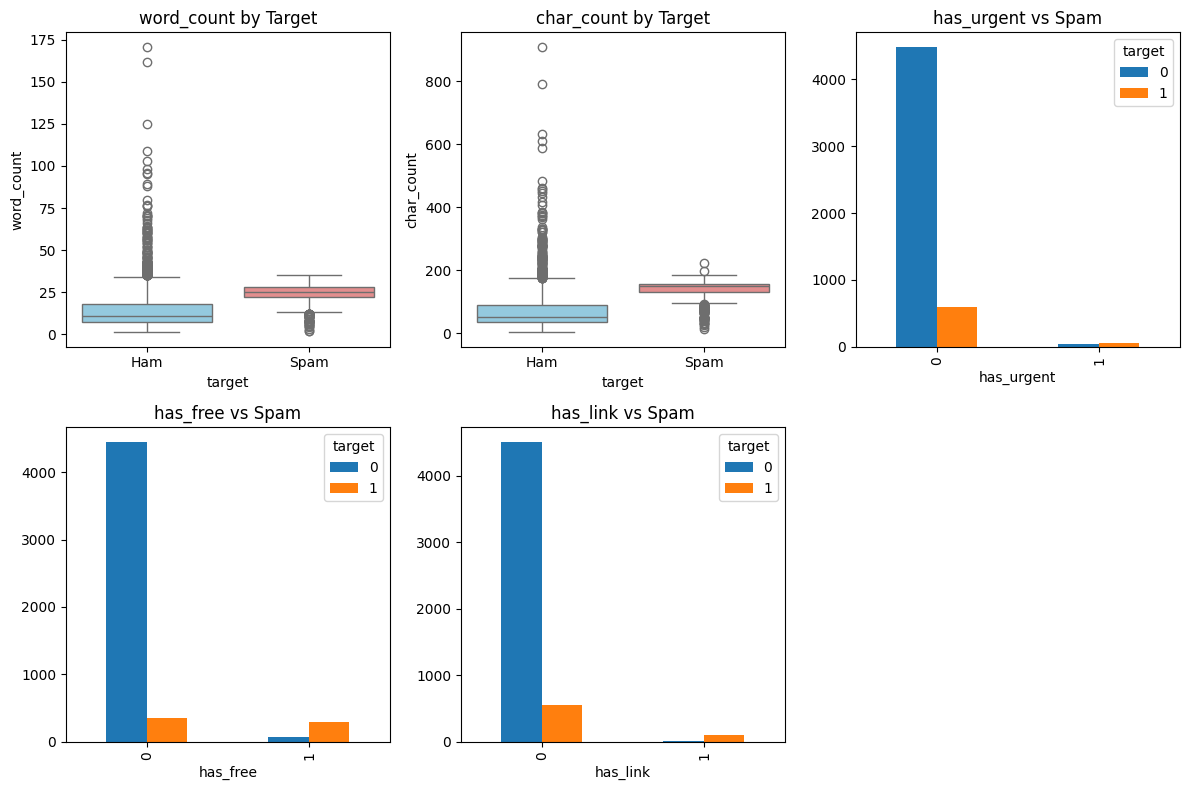

In [34]:
feature_columns = ['word_count', 'char_count', 'has_urgent', 'has_free', 'has_link']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_columns, 1):
    plt.subplot(2,3,i)
    if feature in ['has_urgent', 'has_free', 'has_link']:
        pd.crosstab(df[feature], df['target']).plot(kind='bar', ax=plt.gca())
        plt.title(f'{feature} vs Spam')
    else:
        sns.boxplot(x='target', y=feature, data=df, palette=['skyblue', 'lightcoral'], ax=plt.gca())
        plt.title(f'{feature} by Target')
        plt.xticks([0, 1], ['Ham', 'Spam'])
plt.tight_layout()
plt.show()

In [35]:
# Initialize TF-IDF Vectorizer with basic parameters
tfidf = TfidfVectorizer(
    max_features=3000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Fit and transform the messages
X_tfidf = tfidf.fit_transform(df['cleaned_message'])

print(f"TF-IDF Shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

TF-IDF Shape: (5169, 3000)
Vocabulary size: 3000


In [36]:
# Combine Feature Matrix with TF-IDF Features
from scipy.sparse import hstack

# Combine TF-IDF features with engineered features
engineered_features = df[['word_count', 'char_count', 'has_urgent', 'has_free', 'has_link']].values

# Convert to sparse matrix and combine with TF-IDF
X_combined = hstack([X_tfidf, engineered_features])

print(f"Combined features shape: {X_combined.shape}")
y = df['target']

Combined features shape: (5169, 3005)


Training set size: 4135
Test set size: 1034

Training Naive Bayes...
Naive Bayes Accuracy: 0.9497

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.97       903
        Spam       0.98      0.62      0.76       131

    accuracy                           0.95      1034
   macro avg       0.96      0.81      0.86      1034
weighted avg       0.95      0.95      0.94      1034



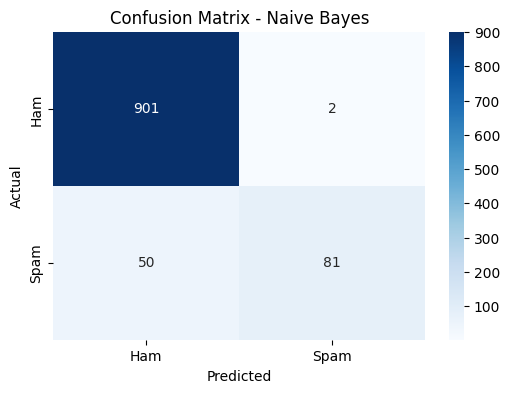


Training Logistic Regression...
Logistic Regression Accuracy: 0.9555

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         Ham       0.96      0.99      0.97       903
        Spam       0.92      0.71      0.80       131

    accuracy                           0.96      1034
   macro avg       0.94      0.85      0.89      1034
weighted avg       0.95      0.96      0.95      1034



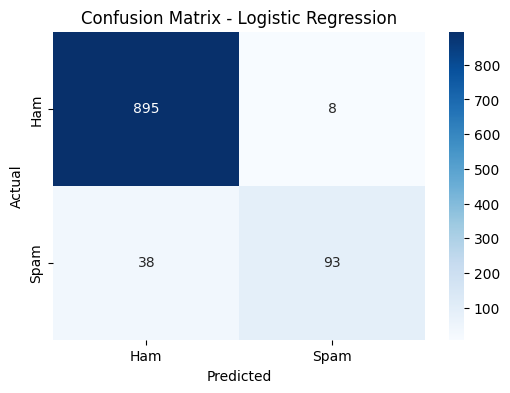


Training SVM...
SVM Accuracy: 0.9787

Classification Report for SVM:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       903
        Spam       0.97      0.86      0.91       131

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



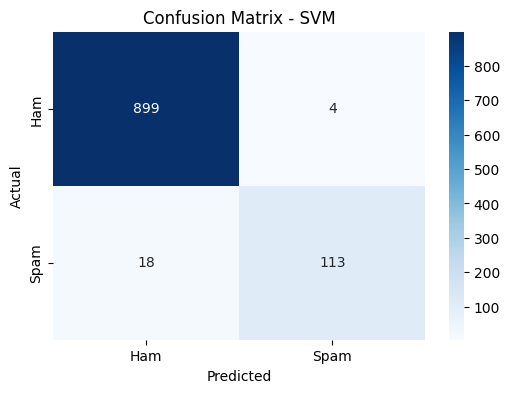

In [37]:
# MODEL TRAINING AND EVALUATION

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

# Train and evaluate each model

results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [38]:
### SIMPLE FEATURE IMPORTANCE ANALYSIS (for Logistic Regression)

if 'Logistic Regression' in models:
    lr_model = models['Logistic Regression']
    
    # Get feature importance (for logistic regression coefficients)
    feature_importance = abs(lr_model.coef_[0])
    
    # Get feature names (TF-IDF features + engineered features)
    feature_names = list(tfidf.get_feature_names_out()) + ['word_count', 'char_count', 'has_urgent', 'has_free', 'has_link']
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 20 Most Important Features:")
    print(importance_df.head(20))

Top 20 Most Important Features:
          feature  importance
1502         ltgt    3.847025
2705          txt    3.164423
2529         text    3.119883
3003     has_free    2.694071
1670          new    2.612625
1598       mobile    2.499498
2076        reply    2.420884
2416         stop    2.343816
3004     has_link    2.174604
283         claim    2.075941
2224      service    2.061224
265          chat    1.987734
2914          won    1.716182
1567      message    1.670304
2796        video    1.619151
994         happy    1.537755
1155           im    1.499737
1672  new message    1.474779
147           bid    1.321126
1135          ill    1.262916


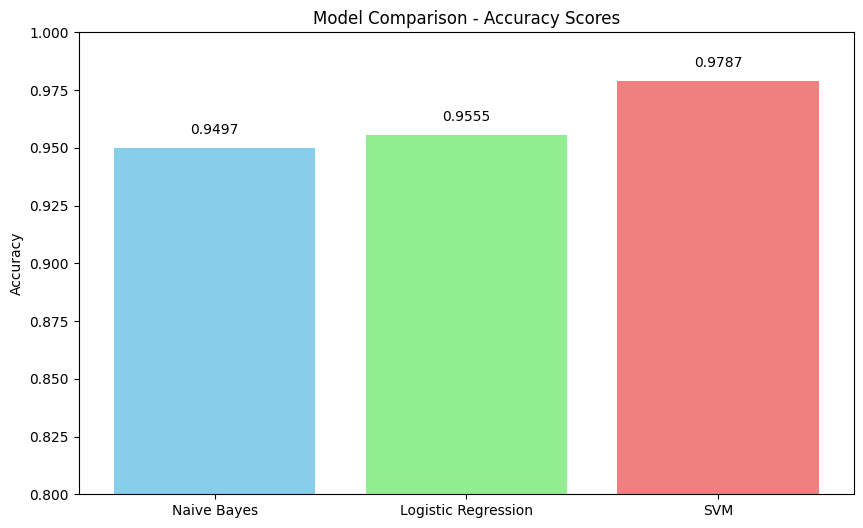


Best Performing Model: SVM with accuracy 0.9787


In [39]:
# Compare model performance

plt.figure(figsize=(10, 6))
models_list = list(models.keys())
accuracy_scores = list(results.values())

bars = plt.bar(models_list, accuracy_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Comparison - Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)

# Annotate bars with accuracy values
for bar, accuracy in zip(bars, accuracy_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height() + 0.005, 
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()
# Print best model
best_model = max(results, key=results.get)
print(f"\nBest Performing Model: {best_model} with accuracy {results[best_model]:.4f}")


In [40]:
# comparing models and saving the best model
import joblib
import os

# Create models directory
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Save ONLY the best performing model with protocol 4 (compatible with Python 3.4+)
best_model_path = os.path.join(models_dir, 'best_model.pkl')
joblib.dump(best_model, best_model_path, protocol=4)
print(f"Best model saved as '{best_model_path}'")

# Save the TF-IDF vectorizer
tfidf_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, tfidf_path, protocol=4)
print(f"TF-IDF vectorizer saved as '{tfidf_path}'")

Best model saved as 'models\best_model.pkl'
TF-IDF vectorizer saved as 'models\tfidf_vectorizer.pkl'
